![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Explainability for Random Forest Models

In this Notebook we will show you different methods that can be used for interpreting Random Forest models. We will demonstrate you how to compare those methods and choose the appropriate one.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button. This will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-random-forest/Bio-5-Tutorial_XAI_for_RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [32]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch ECCB-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials

# Install additional packages and fix package versions
# %pip install fgclustering
# %pip install shap

### Imports

Let's start with importing all required Python packages.

In [33]:
# Load the required packages

import sys

import numpy as np
import pandas as pd

from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score

import shap
from fgclustering import FgClustering
from sklearn.metrics import get_scorer
from sklearn.inspection import permutation_importance

sys.path.append('./')
import utils

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [34]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data Preparation: Acute Myeloid Leukemia (AML) Dataset

In this notebook, we will work with an **Acute Myeloid Leukemia (AML) dataset** from ["Scalable prediction of acute myeloid leukemia using high-dimensional machine learning and blood transcriptomics" Warnat-Herresthal et al. (2020)](https://doi.org/10.1016/j.isci.2019.100780), containing normalized gene expression values for AML samples, samples of other leukemia, and healthy samples or other diseases from Affymetrix HG-U133A and HG-U133 2.0 or RNA-seq. The pre-processing of the dataset is described in the *readme.md* file. In this notebook, we will only use the RNA-Seq data. The datasets consist of a total of 1181 samples with 508 AML, 74 Leukemia and 599 healthy/other samples. The features of this dataset are > 12.000 normalized gene expression values. Our goal is to **predict the AML status** and find out the major differences between AML - non-AML samples.

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTsDAIZopPfjESyUFvfwCwwzpaCht6wabs96g&s" width="700" /></center>

<font size=1> Source: [Link](https://www.hopkinsmedicine.org/health/conditions-and-diseases/leukemia/acute-myelogenous-leukemia)

First we load the metadata and the gene expression data, then merge both dataframes and have a look at the first few lines of the dataset.

In [35]:
# Load metadata and labels
dataset3_info = pd.read_csv("../data/dataset_bio/AML_dataset_3_info.csv")
dataset3_info.drop(["Dataset", "Tissue", "FAB", "Filename"], axis=1, inplace=True)
dataset3_info[["Condition", "Disease", "GSE", "sample_id"]] = dataset3_info[["Condition", "Disease", "GSE", "sample_id"]].astype("category")

# Load features
dataset3 = pd.read_csv("../data/dataset_bio/AML_dataset_3_processed.csv.zip",compression='zip', index_col=0)

# Merge labels and features by sample id
data = pd.merge(dataset3_info, dataset3, on="sample_id", how = "inner")

# Relabel target
data['Condition'] = data['Condition'].map({"CONTROL": '0_Control', "CASE": '1_Cancer'})

print(f"Number of missing values in dataset: {sum(data.isnull().sum())}")
data.head()

Number of missing values in dataset: 0


,sample_id,GSE,Condition,Disease,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,...,WNT6,RABEP2,FKBP15,LRCH4,MEX3D,BCAN,ACTB,GAPDH,MIR3648-2,MIR3648-1
0,GSM1113367,Henn (GSE45735),0_Control,influenca vaccination,147.85,7007.87,141.63,1022.59,262.83,11257.86,...,9.99,730.56,5545.19,6813.02,101.23,0.00,148347.65,33263.69,0.0,0.0
1,GSM1113368,Henn (GSE45735),0_Control,influenca vaccination,207.72,5185.28,405.25,878.79,316.56,11351.47,...,9.38,583.07,6281.28,6338.44,118.57,8.45,187153.55,41616.83,0.0,0.0
2,GSM1113369,Henn (GSE45735),0_Control,influenca vaccination,146.11,7372.09,169.61,930.70,346.37,10340.02,...,19.87,620.16,6038.99,6943.60,77.93,0.00,185930.13,39655.11,0.0,0.0
3,GSM1113370,Henn (GSE45735),0_Control,influenca vaccination,143.40,7640.60,216.64,966.73,236.30,10738.93,...,12.99,580.72,5999.00,6441.42,74.72,8.70,184032.74,36943.07,0.0,0.0
4,GSM1113371,Henn (GSE45735),0_Control,influenca vaccination,124.50,11859.19,156.66,974.51,361.45,22281.94,...,27.63,1087.38,4166.34,10284.33,71.49,0.00,178619.25,33598.66,0.0,0.0


A first inspection of our dataset indicates that we don't have any missing values and that apart from the sample ID and Condition, we have information on the study (GSE) and the disease category for control and cancer samples. 

Let's have a look at the number of control and cancer samples and at the different disease categories for the control samples we have in our dataset.

In [36]:
Counter(data["Condition"])

Counter({'0_Control': 673, '1_Cancer': 508})

In [37]:
counter = Counter(data[data.Condition == "0_Control"].Disease)
counter.most_common()

[('JIA', 132),
 ('TB.vaccination', 119),
 ('Lyme disease', 84),
 ('healthy', 65),
 ('influenca vaccination', 63),
 ('MDS', 35),
 ('Plasmodium vivax challenge', 24),
 ('Polycystic', 16),
 ('CML', 14),
 ('CLL', 13),
 ('ALL', 12),
 ('Diabetes Type 1', 12),
 ('Hypertension nephrosclerosis', 11),
 ('Diabetes Type 2', 9),
 ('RSV infection', 8),
 ('Glom-sclerosis chr&unspecified', 7),
 ('Unknown', 6),
 ('FSGS-Focal sclerosing GN', 6),
 ('T.ALL', 5),
 ('Nephritis', 4),
 ('Cystinosis', 4),
 ('Lupus (SLE)', 3),
 ("Wegener's Granulomatosis", 3),
 ('Thin basement membrane dz', 3),
 ('Nephropathy', 3),
 ('MPGN-membranoproliferative?typ', 3),
 ('HRV infection', 3),
 ('GN-membranous glom.nephritis', 2),
 ("Alport's/Famil Hered neph", 2),
 ('GN-other chronicGlom.nephritis', 2)]

We can see that the target variable is balanced between control and cancer samples and that we have 30 disease categories in the control group with the most frequent categories being JIA, TB vaccinated, Lyme disease, healthy and influenca vaccinated.

In [38]:
print(f"Number of features in our dataset: {data.shape[1]}")

Number of features in our dataset: 12712


We have gene expression values for > 12.000 genes in our dataset. For sake of runtime, we will reduce the number of features to the top 2000 genes with the highest variance.

In [39]:
top_n = 500

data_genes = data.drop(["Condition", "Disease", "GSE", "sample_id"], axis=1)

data_genes_variance = data_genes.var()
selected_features = data_genes_variance.nlargest(top_n).index

## Trainnig a Random Forest Model for Multi-Source Datasets

As described in the associated paper, this dataset consists of data from 23 studeis downloaded from GEO. To train a Random Forest model on data from multiple sources, there exist different data sampling strategies to obtain training and test sets:

1. **random sampling**: 
   - random sampling of training and test sets (repeated 100 x) pooled from all studies in one dataset 
   - diverse study-specific effects and sources of study-to-study variation (e.g. batch effects) can pose problems in the context of predictive tests for clinical applications because predictors that perform well within one study may perform worse when applied to data from new studies with implications for practical generalizability
2. **cross-study sampling**
   - sample training and testing sets from different studies, i.e. any individual study from which any sample was included into the training dataset was entirely absent from the test set, and vice versa
   - can only be used if the distribution of target classes allows it, i.e. if cross-study sampling doesn't lead to an imbalanced dataset


Here we will use the **cross-study sampling** stategy to obtain our training and test sets. For our training set we will use all studies with > 50 samples and for our test set we will use the remaning studeis with < 50 samples. This results in ~80% of the data being attributes to the training set (529 control vs 416 cancer) and ~20% to the test set (144 control vs 92 cancer). 

*Note: for simplicity we will use random sampling in the hyperparameter tuning cross-validation setting. However, it would be recommended to use the cross-sample sampling for the validation set as well, if the distribution of target classes allows it.*

In [40]:
# studies with > 50 samples
studies_train = ['Lavallee (GSE67039)', 'Hoft (GSE87186)', 'Wong (GSE79970)', 'Bouquet (GSE63085)', 'Dorr (GSE86884)', 'Lavallee (GSE62190)', 'Garzon (GSE63646)', 'GSE81259', 'Henn (GSE45735)'] 
# studies with < 50 samples
studies_test = ['Lavallee (GSE49642)', 'Lavallee (GSE52656)', 'Lavallee (GSE66917)', 'Chen (GSE32874)', 'Rojas.Pena (GSE67184)', 'Meldi (GSE61162)', 'Simon (GSE49601)', 'Hoek (GSE64655)', 'Divinge (GSE58335)', 'Spinella (GSE78785)', 'Doss (GSE63703)', 'GSE72790', 'GSE63816', 'GSE85712']

In [41]:
data_train = data[data["GSE"].isin(studies_train)].copy()
data_train.reset_index(inplace=True, drop=True)

X_train = data_train[selected_features]
y_train = data_train.Condition

data_test = data[data["GSE"].isin(studies_test)].copy()
data_test.reset_index(inplace=True, drop=True)

X_test = data_test[selected_features]
y_test = data_test.Condition

print(f'Number of training samples: {len(X_train.index)} with {sum(y_train=="0_Control")} healthy and {sum(y_train=="1_Cancer")} cancer samples.')
print(f'Number of training samples: {len(X_test.index)} with {sum(y_test=="0_Control")} healthy and {sum(y_test=="1_Cancer")} cancer samples.')


Number of training samples: 945 with 529 healthy and 416 cancer samples.
Number of training samples: 236 with 144 healthy and 92 cancer samples.


Now, that we have our training and test set, let's train our Random Forest Classifier.

In [42]:
grid = {"max_depth":[2, 5, 10], 
        "max_features": ['sqrt', 'log2'],
        "bootstrap": [True],
        'n_estimators': [1000],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy'],}

In [43]:
# Define a classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=4)

# Define a grid search with 5-fold CV and fit 
gridsearch_classifier = GridSearchCV(classifier, grid, cv=5, scoring='accuracy', verbose=0)
gridsearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=4, oob_score=True,
                                              random_state=42),
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1000]},
             scoring='accuracy')

In [44]:
# Check the results
print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_*100, 2)}% accuracy and the parameters of best prediction model are:')
print(gridsearch_classifier.best_params_)

The mean cross-validated score of the best model is 99.79% accuracy and the parameters of best prediction model are:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 1000}


In [45]:
# Take the best estimator
rf = gridsearch_classifier.best_estimator_

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, y_pred_train)*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, y_pred_test)*100,2)} % accuracy.')

Model Performance on training data: 100.0 % accuracy.
Model Performance on test data: 72.92 % accuracy.


The generalization of our model is ok with 73% test accuracy. The lower test accuracy is expected since we use the cross-study sampling strategy. Using the random sampling strategy would most likely lead to better, but over confident, model performance.

Below, we plot the correlation between the model features that we should be aware of when using some of the XAI methods.

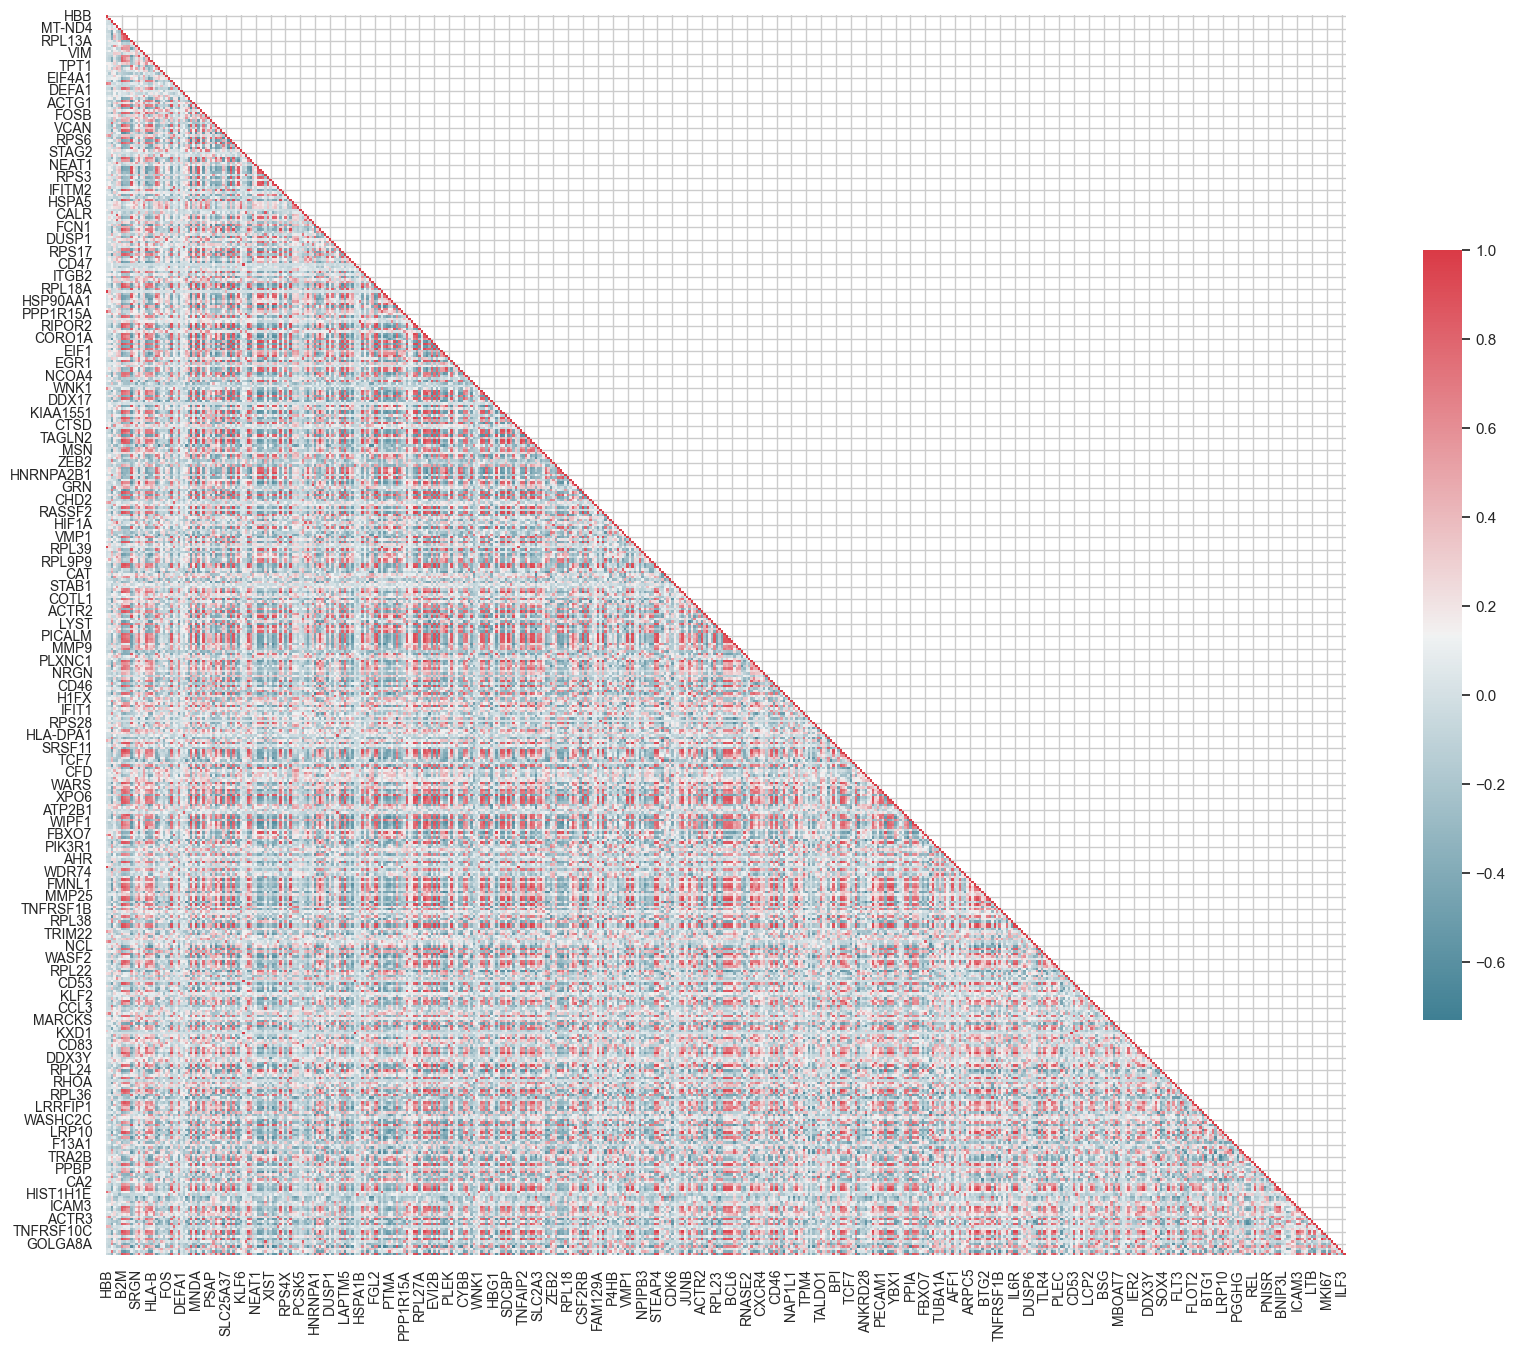

In [46]:
utils.plot_correlation_matrix(X_train, annot=False, figsize=(20,20), shrink=0.5)

--------

## Now, what are our possibilities to interpret a Random Forest model?

### Interpretation with Feature Importance Measures

#### Permutation Feature Importance

In the [Bio-1-Tutorial_PermutationFeatureImportance.ipynb](./Bio-1-Tutorial_PermutationFeatureImportance.ipynb) notebook you were introduced to the model-agnostic Permutation Feature Importance. Recall, the Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly permuted. This procedure breaks the relationship between the feature and the target. Thus the drop in the model score is indicative of how much the model depends on the feature. Lets now apply it to our penguins dataset:

In [47]:
# we only want to plot the top 20 features for sake of visualisation
top_n = 40

<font color='green'>

#### Task 1: Calculate permutation feature importance for the trained Random Forest model. Therefore, define the appropriate scorer and compute the permutation feature importance scores by filling in the two lines below.


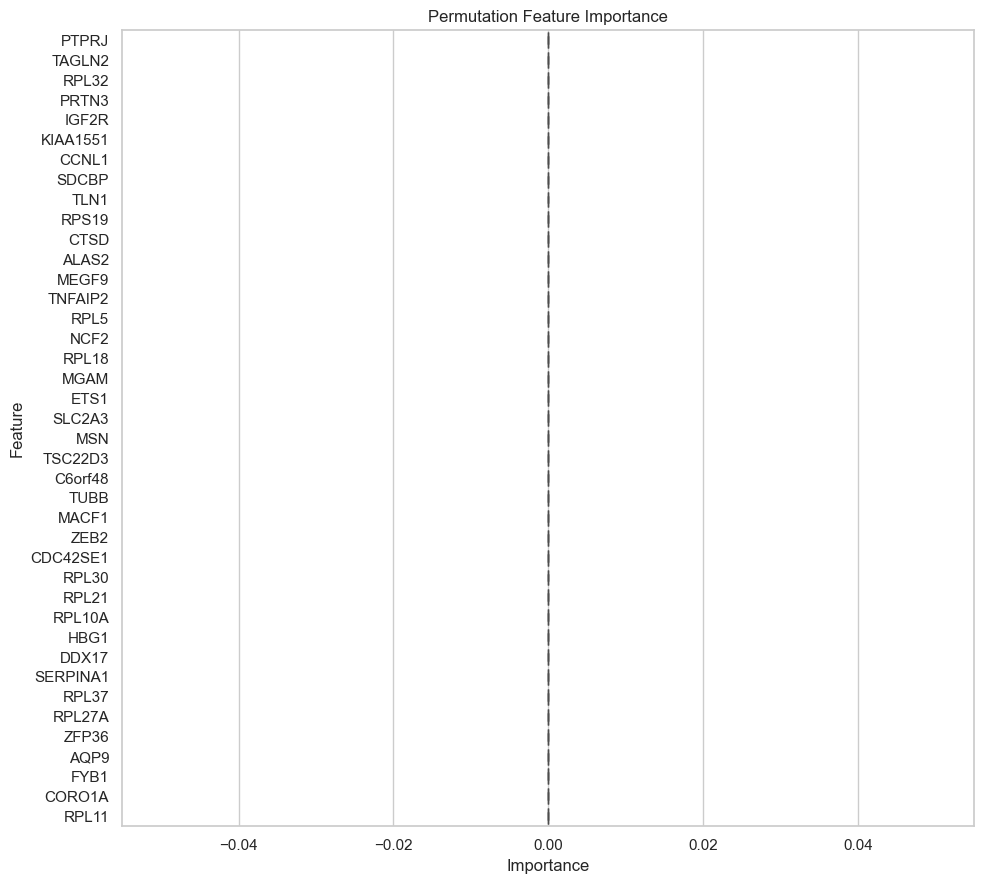

In [48]:
scorer = get_scorer("accuracy")
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=seed, n_jobs=4)
utils.plot_permutation_feature_importance(result=result, data=X_train, title="Permutation Feature Importance", figsize=(10,9), top_n=top_n)

#### Random Forest Feature Importance

An alternative to Permutation Feature Importance is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute `feature_importances_` .

Lets plot the feature importance based on mean decrease in impurity:

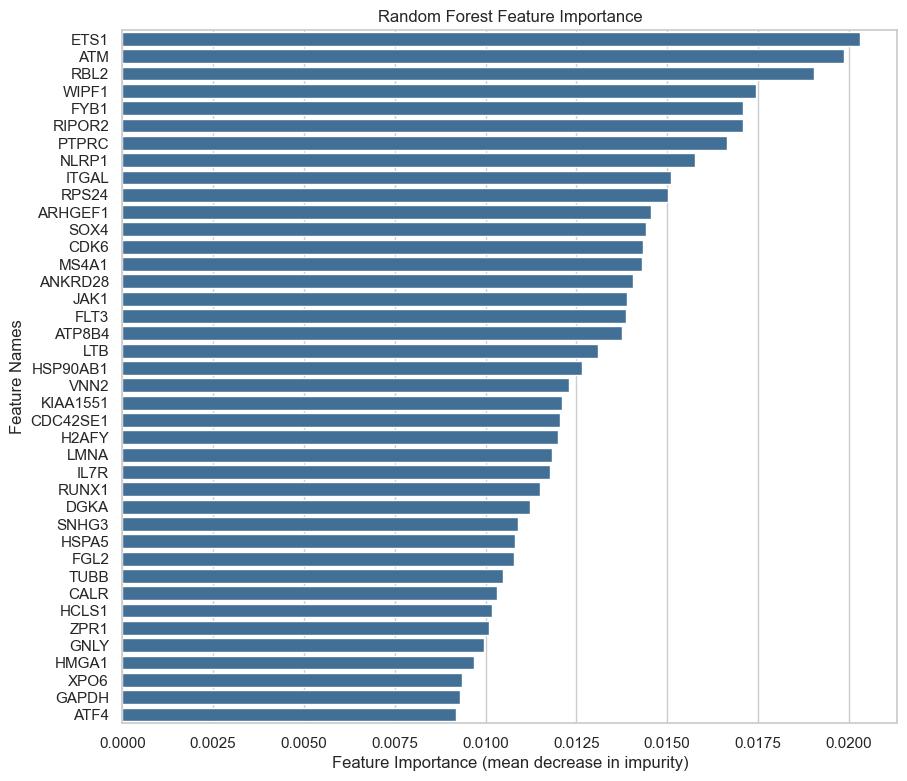

In [49]:
utils.plot_impurity_feature_importance(rf.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", top_n=top_n, figsize=(10,9))

### Interpretation with SHAP

In the [Bio-3-Tutorial_SHAP.ipynb](./Bio-3-Tutorial_SHAP.ipynb) notebook you, were introduced to the model-agnostic SHAP method. Recall, with SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

<font color='green'>

#### Task 2: Run SHAP on the trained Random Forest model for the training data. Therefore, define the appropriate explainer and calculate the SHAP values by filling in the lines below.

In [50]:
# run SHAP
explainer = shap.TreeExplainer(model=rf, data=shap.maskers.Independent(X_train, max_samples=len(X_train)), model_output="probability")
shap_values = explainer(X_train)

# get original unscaled feature values
shap_values.data = X_train.round(4) 

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

 99%|===================| 1879/1890 [01:18<00:00]        

Remember that the SHAP values explain why a prediction for a single observation is different from the average prediction for all the observations in the data set. For our AML classifier, the shap explainer produces two expected values, corresponding to the average predicted probability for each class, which is essentially the predicted class frequency in the dataset.

In [51]:
# average prediction for the dataset
ev = explainer.expected_value
pm = np.mean(rf.predict_proba(X_train), axis=0)

print(f'Models average prediction for our data set is for class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}')
print(f'Expected value for our data set is for class 0: {round(ev[0],3)}, for class 1: {round(ev[1],3)}')

Models average prediction for our data set is for class 0: 0.56, for class 1: 0.44
Expected value for our data set is for class 0: 0.56, for class 1: 0.44


To get a general overview on the features with the highest contributions, we can plot the average absolute SHAP values for each class.

<font color='green'>

#### Task 3: Plot the summary plot as barplot for the absolute SHAP values by filling in the line below.

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_75935/3206266506.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


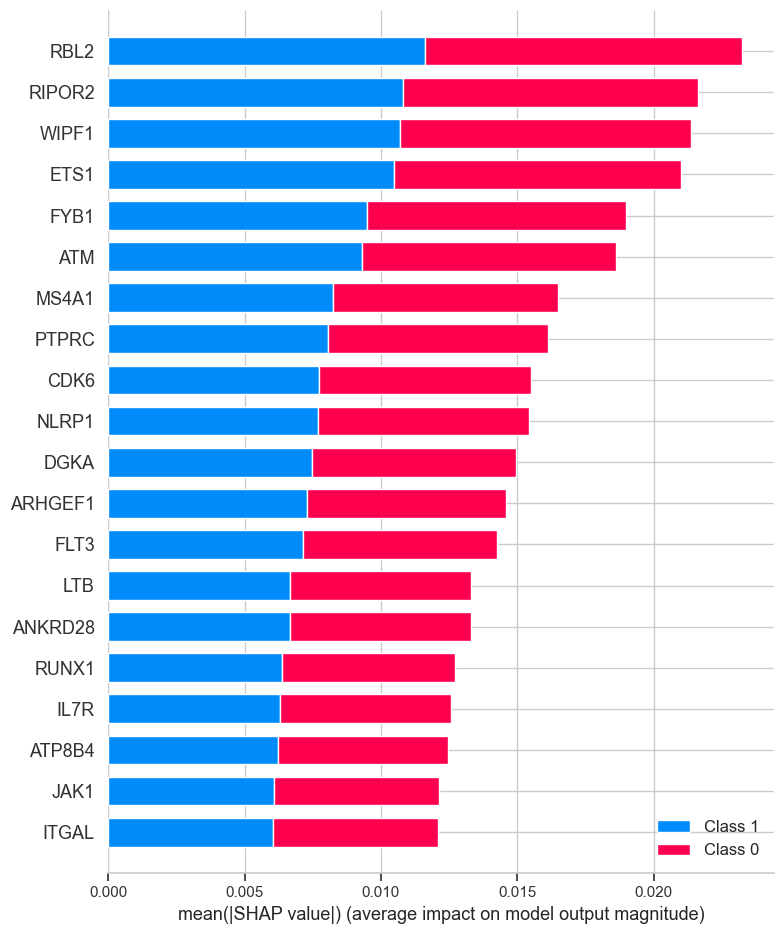

In [52]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

For a more granular view we can use the beeswarm or violin plots. Remember, those have to be plotted class-wise.

<font color='green'>

#### Task 4: Plot the summary plot as a beeswarm plot for the SHAP values by filling in the line below. For multi-class calssification, it has to be plotted per class. Only plot the *1_cancer* class.

/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_75935/3635049124.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


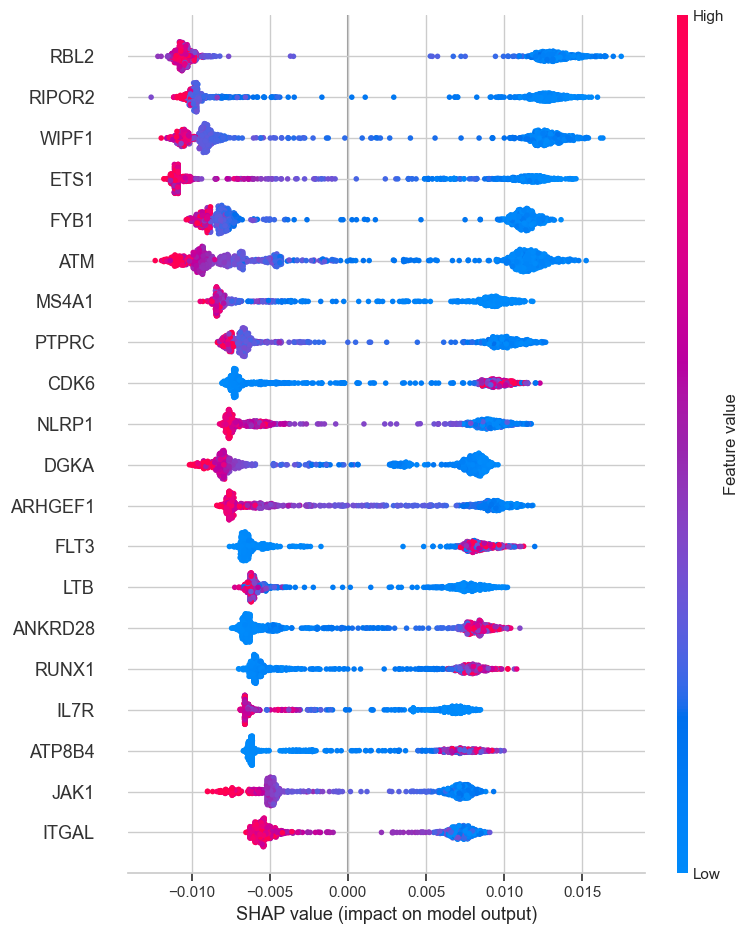

In [53]:
# summary plot for class 1 = cancer
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)

<font color='green'>

#### Task 5: Compare the results of the training data to the SHAP results on the test data.

In [54]:
# run SHAP
explainer = shap.TreeExplainer(model=rf, data=shap.maskers.Independent(X_test, max_samples=len(X_test)), model_output="probability")
shap_values = explainer(X_test)

# get original unscaled feature values
shap_values.data = X_test.round(4) 

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

# average prediction for the dataset
ev = explainer.expected_value
pm = np.mean(rf.predict_proba(X_test), axis=0)

print(f'Models average prediction for our data set is for class 0: {round(pm[0],3)}, for class 1: {round(pm[1],3)}')
print(f'Expected value for our data set is for class 0: {round(ev[0],3)}, for class 1: {round(ev[1],3)}')

Models average prediction for our data set is for class 0: 0.304, for class 1: 0.696
Expected value for our data set is for class 0: 0.304, for class 1: 0.696


/var/folders/8g/7wdchs993770j0nbzbt5p0_r0000gn/T/ipykernel_75935/3206266506.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


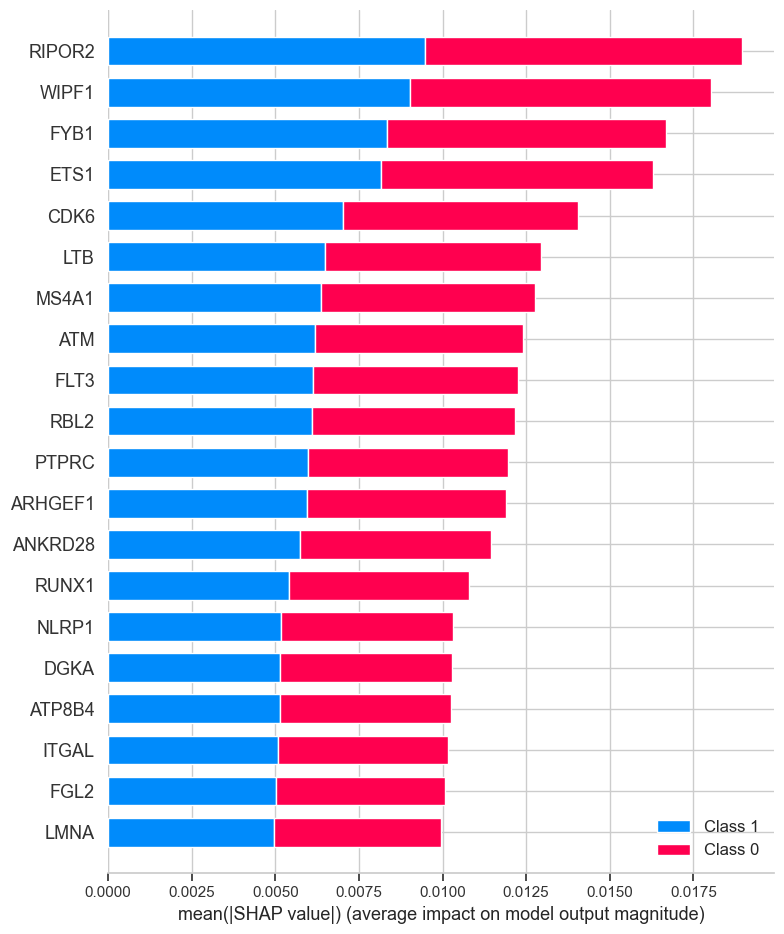

In [55]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')

### Interpretation with Forest-Guided Clustering

In the [Bio-4-Tutorial_FGC.ipynb](./Bio-4-Tutorial_FGC.ipynb) notebook you were introduced to the Random Forest specific FGC method. Recall, FGC does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model.

Even though the Random Forest Feature Importance and SHAP do overcome some disadvantages of Permutation Feature Importance and give us some information about class-wise feature contributions, they do not give us further insights into the decision paths of the Random Forest model. Forest-Guided Clustering (FGC) leverages the tree structure of Random Forest models to get insights into the decision making process of the model, which might be able to help us out here... 

<font color='green'>

#### Task 6: Run FGC on the trained Random Forest model. Therefore, define the FgClustering object and run fgc by filling in the lines below.

In [56]:
# create an FGC instance
fgc = FgClustering(model=rf, data=X_train, target_column=y_train)

# Run the fgc instance
fgc.run(n_jobs=4)

Interpreting RandomForestClassifier


 17%|█▋        | 1/6 [00:03<00:15,  3.02s/it]

For number of cluster 2 the Jaccard Index is 1.0
For number of cluster 2 the score is 0.0


 33%|███▎      | 2/6 [00:03<00:06,  1.53s/it]

For number of cluster 3 the Jaccard Index is 0.8987401165169956
For number of cluster 3 the score is 0.0


 50%|█████     | 3/6 [00:04<00:03,  1.13s/it]

For number of cluster 4 the Jaccard Index is 0.6084484707806656
For number of cluster 4 the score is 0.0


 67%|██████▋   | 4/6 [00:05<00:02,  1.03s/it]

For number of cluster 5 the Jaccard Index is 0.45233638330829956
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:06<00:01,  1.07s/it]

For number of cluster 6 the Jaccard Index is 0.6577777794786179
For number of cluster 6 the score is 0.0


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

For number of cluster 7 the Jaccard Index is 0.11804573298073037
Clustering is instable, no score computed!
Optimal number of cluster is: 2


The results from the FGC optimizer indicate that we have three k's that lead to stable clusterings and a score of 0, i.e. k=2, k=3 and k=4. To get some additional granularity we choose to recompute the statistics with *k=4*.

In [57]:
# Rerun with k=4
fgc.run(k=4)

Use 4 as number of cluster


Lets now plot the global and local FGC feature importance for the top 20 important features.

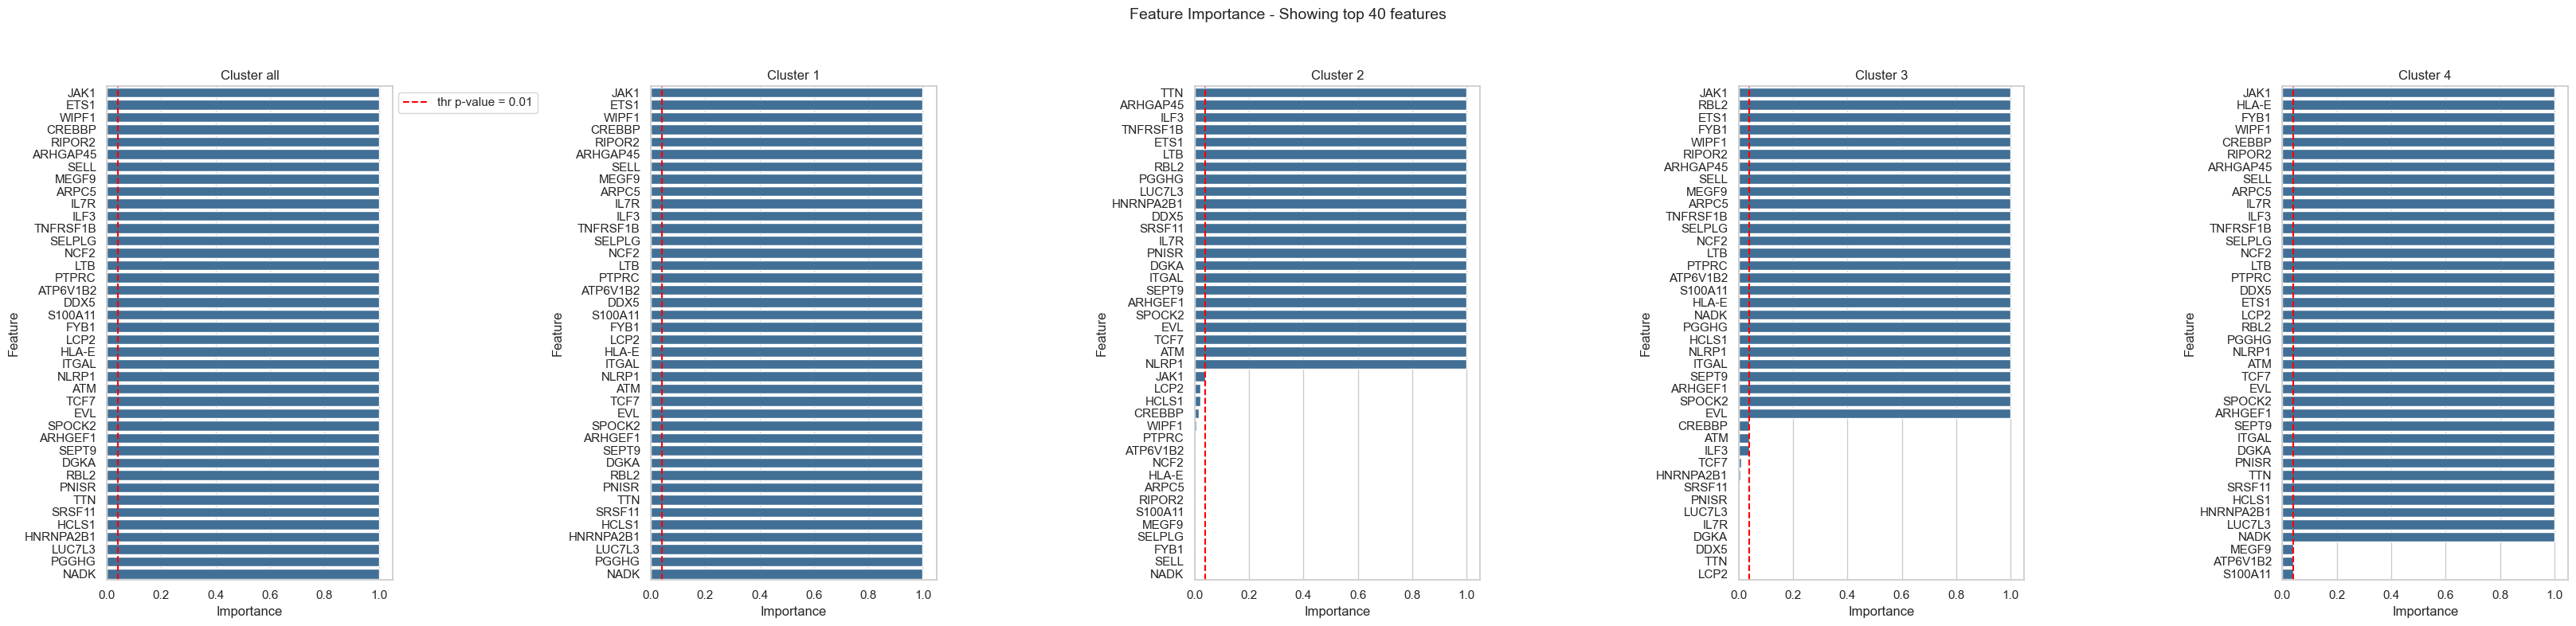

In [58]:
%matplotlib inline
# Plot global feature importance
fgc.plot_feature_importance(thr_pvalue=0.01, top_n=top_n, num_cols=5)

One of the major advantages of FGC is the visualization of the Random Forest decision path, which can help us to understand the decision making process of our model.

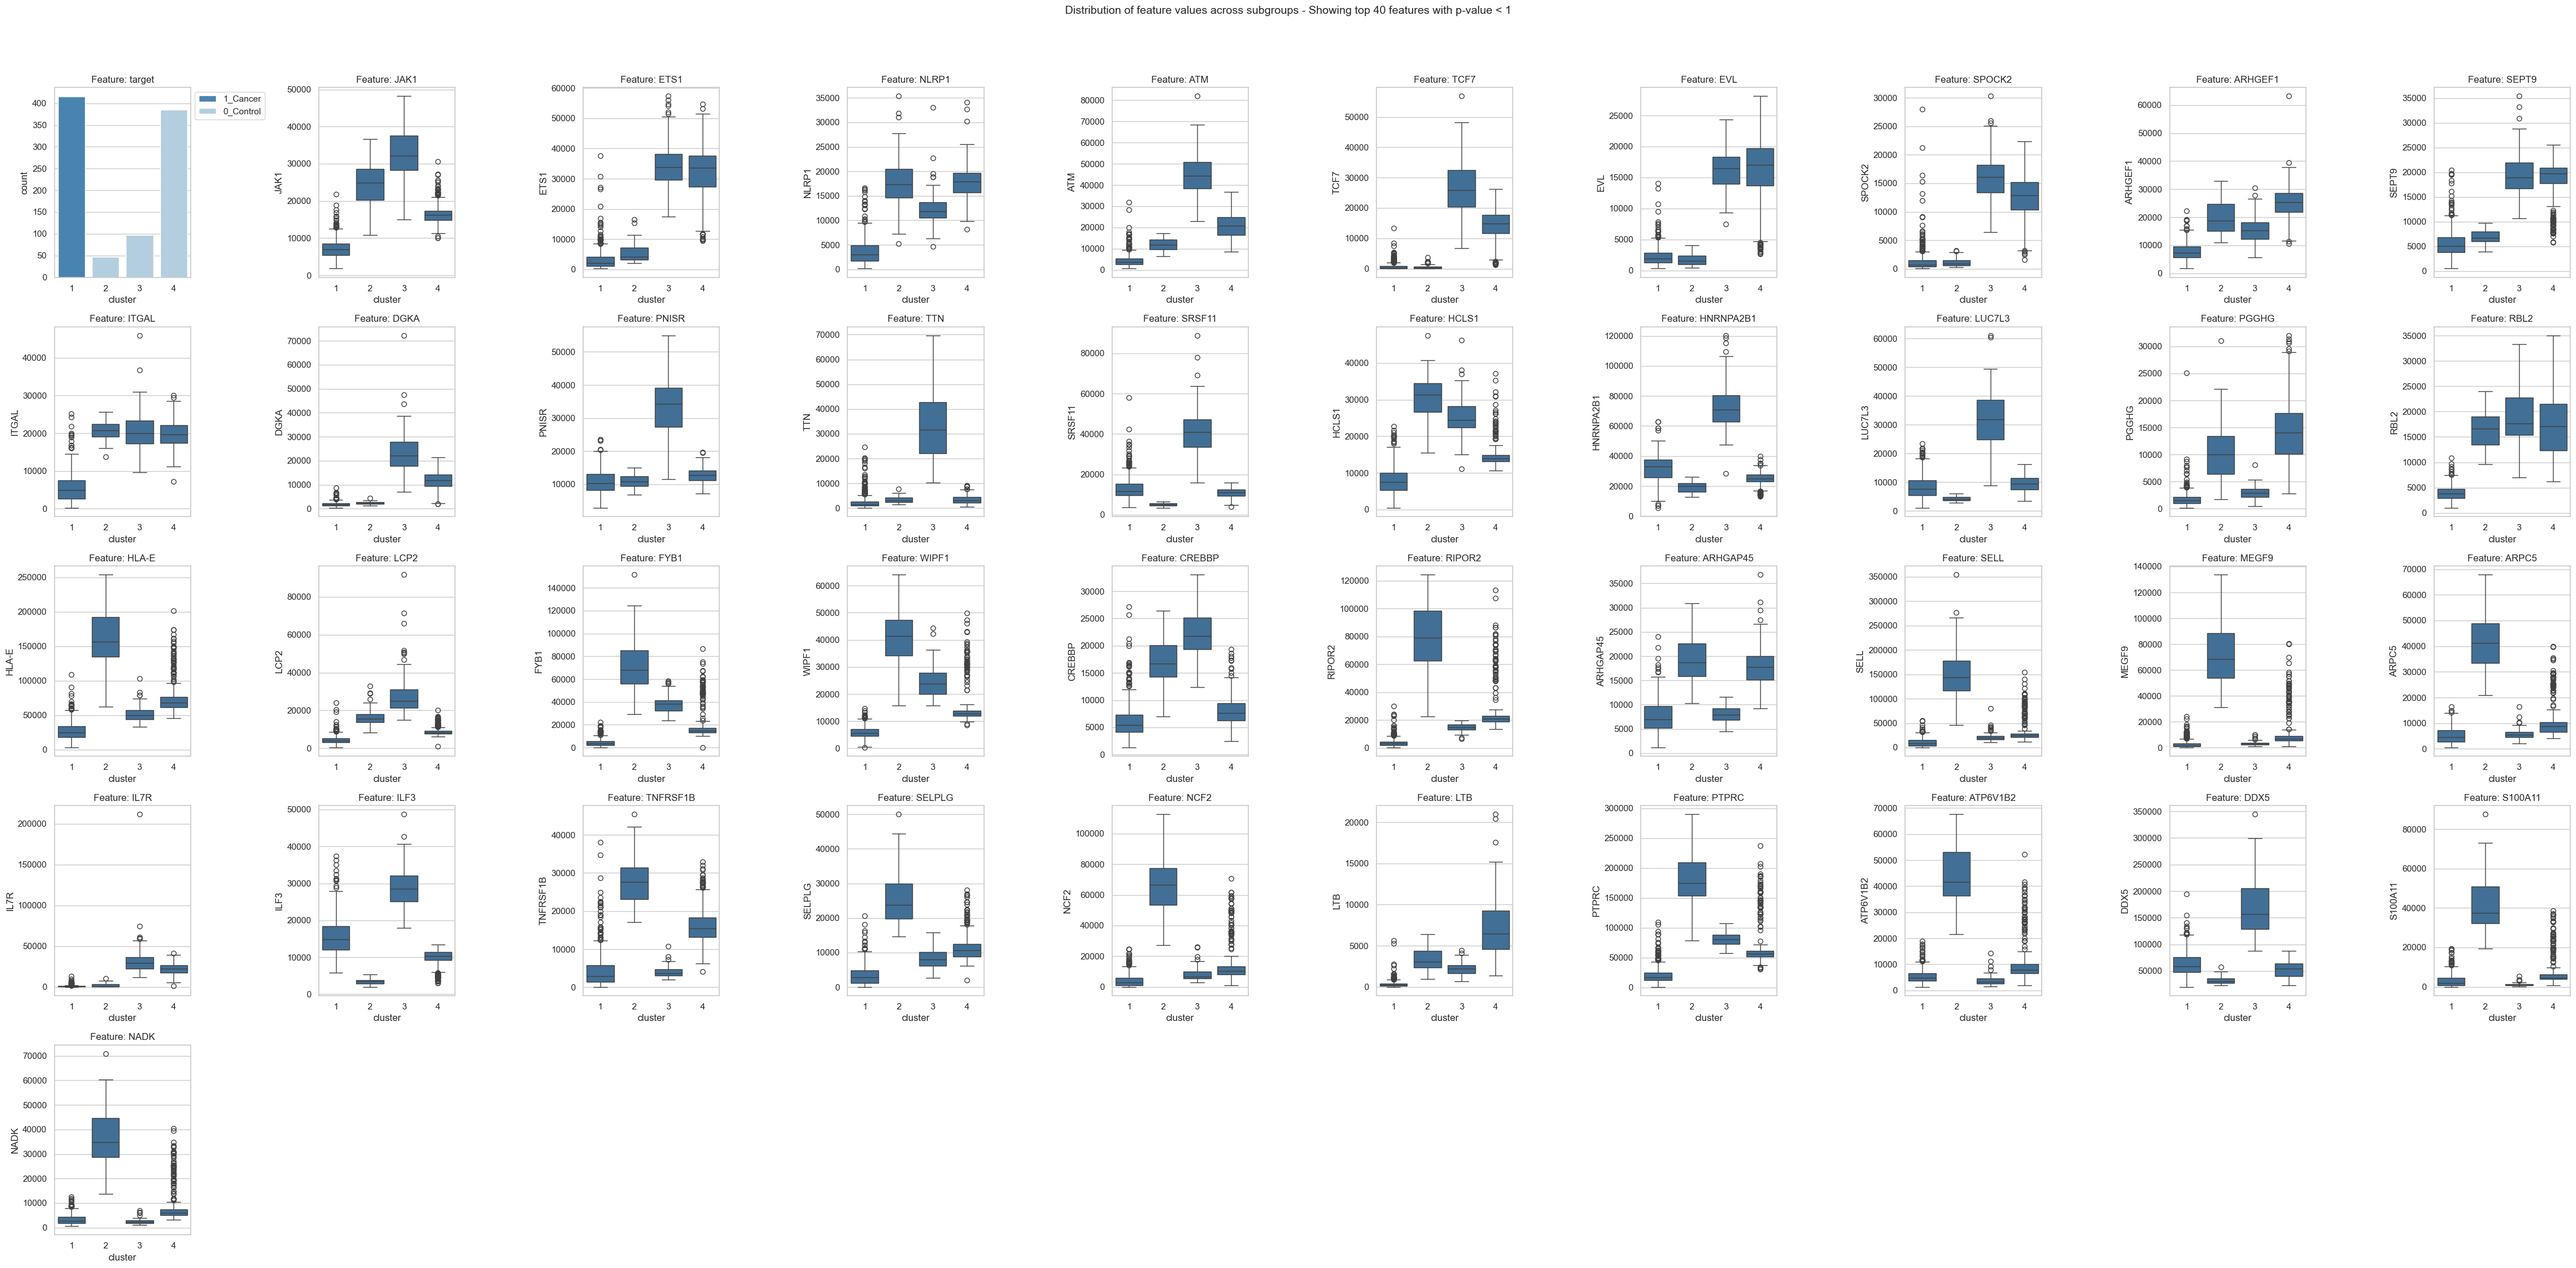

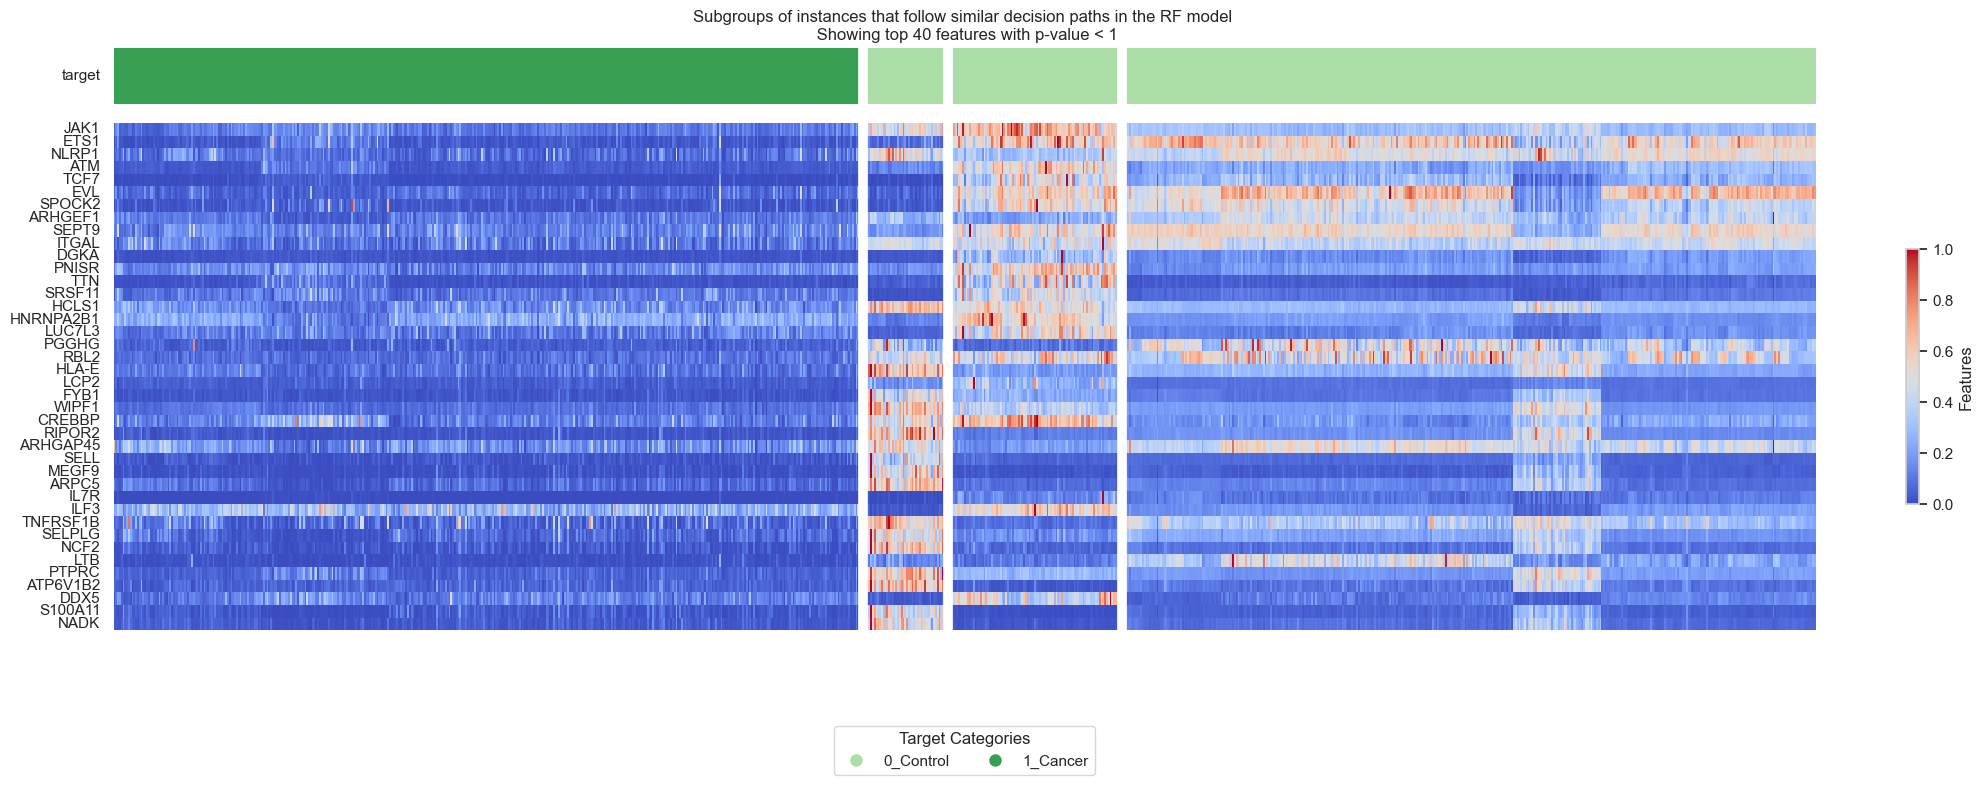

In [59]:
fgc.plot_decision_paths(num_cols = 10, top_n=top_n)

A second advantage is that we can visualize feature distributions across cluster of features that were not used in the model training process. Hence, we can investigate if features like *GSE* (study) or Disease have any hidden influence on the model. Therefore, we use the function `calculate_statistics`, which re-calculates the feature importances and can be used to plot the cluster heatmap for instance.

In [60]:
top_features = fgc.p_value_of_features_ranked.iloc[:, :top_n].columns.to_list() + ["GSE", "Disease"]
fgc.calculate_statistics(data=data_train[top_features], target_column=data_train.Condition)

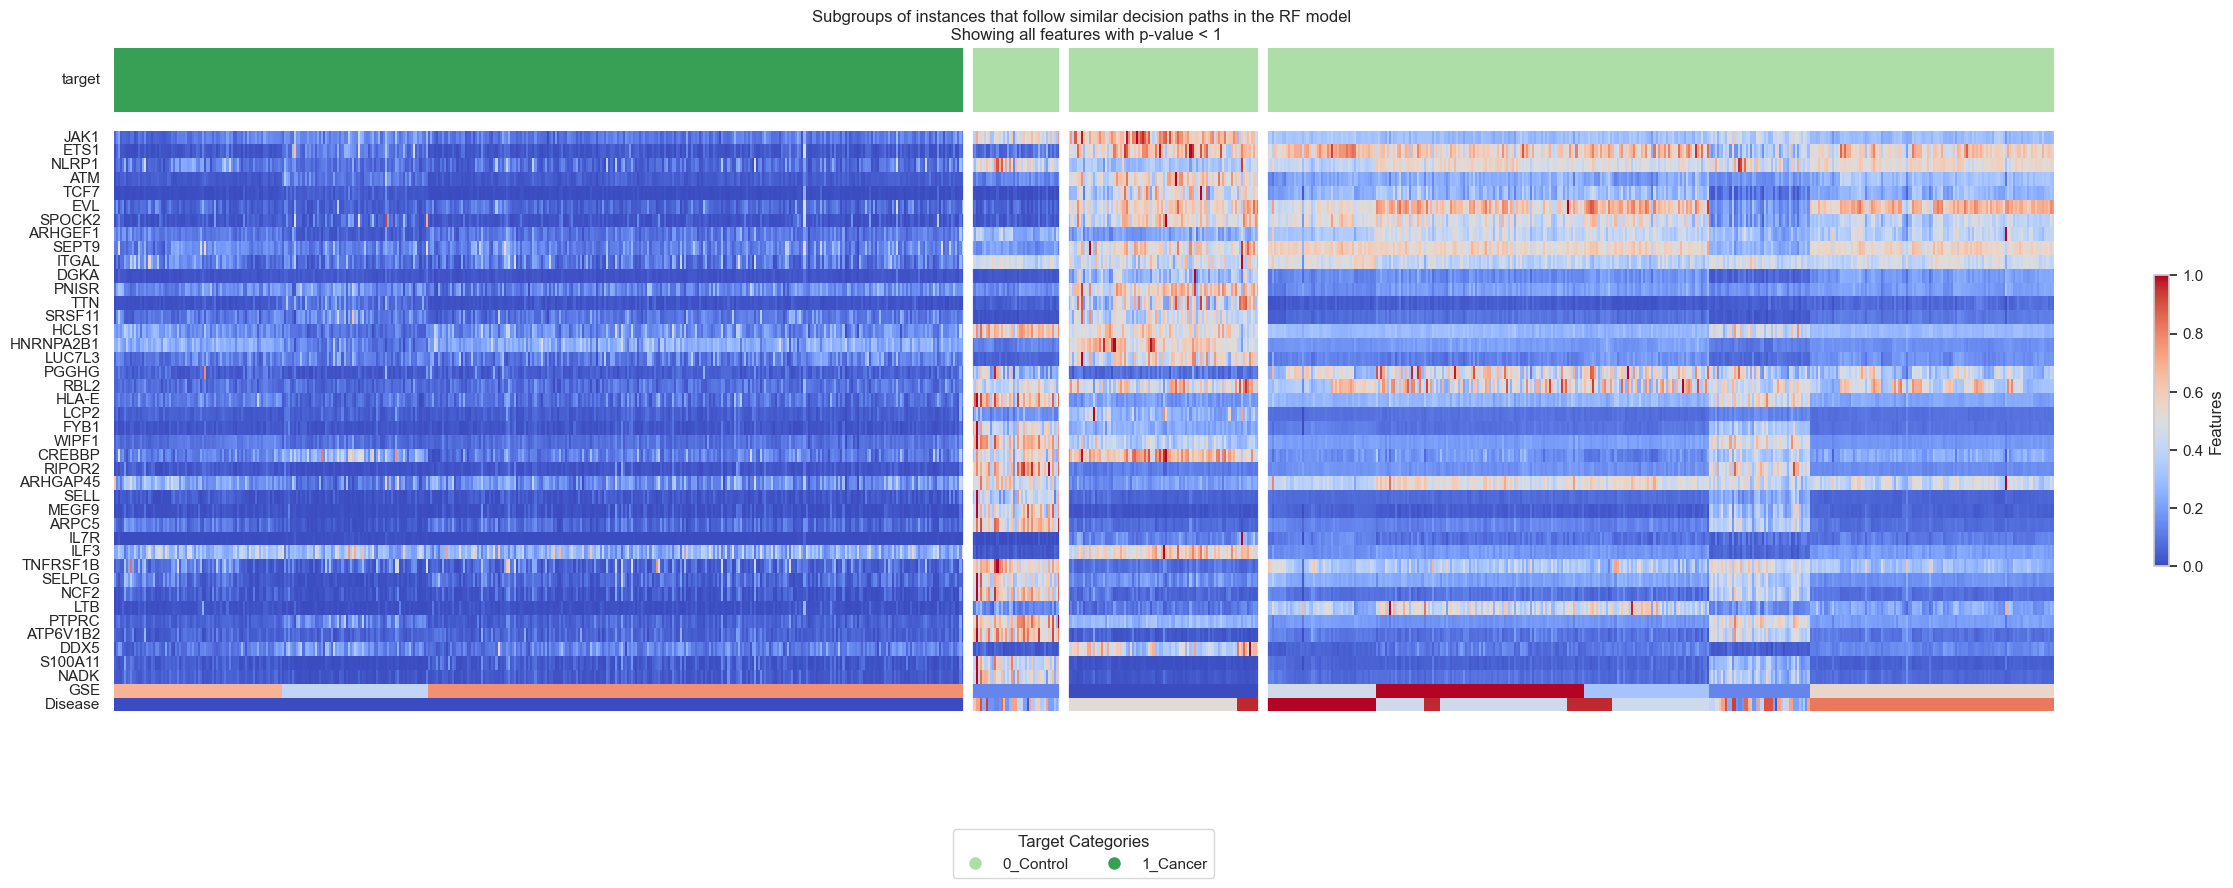

In [62]:
fgc.plot_decision_paths(distributions=False)

<font color='green'>

#### Question 1: What do you observe when comparing the Permutation Feature Importance, Random Forest Feature Importance, SHAP Bar Plot and the FGC Feature Importance?

<font color='grey'>

#### Your Answer: 

SHAP, FGC, and RF feature importance agree to a certain extend on feature importances while Permutation Feature Importance fails to compute importances due to the high degree of correlation in the dataset.


<font color='green'>

#### Question 2: What do you observe when comparing the SHAP Beeswarm Plots and the FGC Decision Path Plot?


<font color='grey'>

#### Your Answer: 

The SHAP beeswarm plot only gives us binary information on the feature attribution, e.g. lower gene expression values of the top important genes are indicative of cancer patients. In comparison, the FGC decision path plot allows for a higher granularity of control sample differentiation, e.g. we have three different cluster of control samples with differential gene epxression of the top important genes. Another advantage of FGC decision path plot is that we can visualize features that are not input into the Random Forest model, e.g. the associated study (GSE) andcontrol disease, but potentially have underlying effects on the model, e.g. batch effect of associated study shown in decision path heatmap plot.

<font color='green'>
